In [87]:
import os
import glob
import math
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import rasterio

def extract_rpc_data(tif_path):
    """Extract RPC data from rgb TIF file"""
    with rasterio.open(tif_path) as src:
        # Get RPC data
        rpc_data = {}
        try:
            # Check if there are RPC tags
            if 'RPC' in src.tag_namespaces():
                rpc_tags = src.tags(ns='RPC')
                
                # Extract all RPC parameters
                rpc_data["LAT_OFF"] = float(rpc_tags.get("LAT_OFF", 0))
                rpc_data["LONG_OFF"] = float(rpc_tags.get("LONG_OFF", 0))
                rpc_data["HEIGHT_OFF"] = float(rpc_tags.get("HEIGHT_OFF", 0))
                rpc_data["LAT_SCALE"] = float(rpc_tags.get("LAT_SCALE", 1))
                rpc_data["LONG_SCALE"] = float(rpc_tags.get("LONG_SCALE", 1))
                rpc_data["HEIGHT_SCALE"] = float(rpc_tags.get("HEIGHT_SCALE", 1))
                rpc_data["LINE_OFF"] = float(rpc_tags.get("LINE_OFF", 0))
                rpc_data["SAMP_OFF"] = float(rpc_tags.get("SAMP_OFF", 0))
                rpc_data["LINE_SCALE"] = float(rpc_tags.get("LINE_SCALE", 1))
                rpc_data["SAMP_SCALE"] = float(rpc_tags.get("SAMP_SCALE", 1))
                
                # Parse coefficient arrays
                for coef in ["LINE_NUM_COEFF", "LINE_DEN_COEFF", "SAMP_NUM_COEFF", "SAMP_DEN_COEFF"]:
                    if coef in rpc_tags:
                        # Parse the coefficients from space-separated string
                        rpc_data[coef] = [float(val) for val in rpc_tags[coef].split()]
        except Exception as e:
            print(f"Error extracting RPC data from {os.path.basename(tif_path)}: {e}")
            return None
        
        return rpc_data

def calculate_viewing_angles(rpc_data):
    """Calculate approximate satellite viewing angles from RPC data"""
    if not rpc_data:
        return None, None
    
    # Extract first-order coefficients for height
    try:
        line_z_coef = rpc_data["LINE_NUM_COEFF"][3]  # Coefficient for Z
        samp_z_coef = rpc_data["SAMP_NUM_COEFF"][3]  # Coefficient for Z
        
        # Estimate off-nadir angle
        gradient_magnitude = math.sqrt(line_z_coef**2 + samp_z_coef**2)
        off_nadir_angle = math.atan(gradient_magnitude) * (180/math.pi) * 30
        off_nadir_angle = min(45, max(0, off_nadir_angle))
        
        # Estimate azimuth angle
        azimuth = math.atan2(samp_z_coef, line_z_coef) * (180/math.pi)
        if azimuth < 0:
            azimuth += 360
            
        return off_nadir_angle, azimuth
    except (KeyError, IndexError) as e:
        print(f"Error calculating viewing angles: {e}")
        return None, None

def estimate_camera_position(lat, lon, alt, off_nadir, azimuth, satellite_height=500000):
    """
    Estimate the camera position in 3D space with flipped x-axis
    
    Args:
        lat, lon, alt: The ground point location (degrees, degrees, meters)
        off_nadir: Off-nadir angle in degrees
        azimuth: Azimuth angle in degrees
        satellite_height: Approximate satellite height in meters
    
    Returns:
        tuple: (camera_x, camera_y, camera_z) in meters in local ENU coordinates
    """
    # Calculate slant range (distance from ground to satellite)
    slant_range = satellite_height / math.cos(math.radians(off_nadir))
    
    # Calculate direction vector components
    # X is East, Y is North, Z is Up
    x = slant_range * math.sin(math.radians(off_nadir)) * math.sin(math.radians(azimuth))
    y = slant_range * math.sin(math.radians(off_nadir)) * math.cos(math.radians(azimuth))
    z = slant_range * math.cos(math.radians(off_nadir))
    
    # Flip the X-axis
    x = -x
    
    return (x, y, z)

def latlon_to_xyz(lat, lon, alt=0, ref_lat=None, ref_lon=None):
    """
    Convert latitude, longitude to local ENU coordinates with flipped x-axis
    
    Args:
        lat, lon: Point coordinates (degrees)
        alt: Altitude in meters
        ref_lat, ref_lon: Reference point (degrees), if None will use the input point
    
    Returns:
        tuple: (x, y, z) in meters in local ENU coordinates
    """
    # If no reference point specified, use the input point
    if ref_lat is None:
        print("No reference point specified, using input point as reference.")
        ref_lat = lat
    if ref_lon is None:
        print("No reference point specified, using input point as reference.")
        ref_lon = lon
    print(f"Reference point: {ref_lat}, {ref_lon}")
    
    # Earth radius in meters
    R = 6378137.0
    
    # Convert to radians
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    ref_lat_rad = math.radians(ref_lat)
    ref_lon_rad = math.radians(ref_lon)
    
    # Calculate distance in east direction (x) - then flip it
    x = -(R * math.cos(ref_lat_rad) * (lon_rad - ref_lon_rad))
    
    # Calculate distance in north direction (y)
    y = R * (lat_rad - ref_lat_rad)
    
    # Z is just the altitude (relative to reference altitude)
    z = alt
    
    return (x, y, z)

def create_rotation_matrix(off_nadir, azimuth):
    """
    Create a rotation matrix from off-nadir angle and azimuth
    with flipped x-axis orientation
    
    Args:
        off_nadir: Off-nadir angle in degrees
        azimuth: Azimuth angle in degrees
        
    Returns:
        numpy.ndarray: 3x3 rotation matrix and components
    """
    # Convert angles to radians
    off_nadir_rad = math.radians(off_nadir)
    azimuth_rad = math.radians(azimuth)
    
    # Create rotation matrices for each axis
    # First, set the camera to point downward (negative Z)
    R_nadir = np.array([
        [-1, 0, 0],   # Changed from -1 to 1 for x-axis flip
        [0, 1, 0],
        [0, 0, -1]  # Points downward
    ])
    
    # Rotation for off-nadir angle (rotation around x-axis)
    R_off_nadir = np.array([
        [1, 0, 0],
        [0, math.cos(off_nadir_rad), -math.sin(off_nadir_rad)],
        [0, math.sin(off_nadir_rad), math.cos(off_nadir_rad)]
    ])
    
    # Rotation for azimuth angle (rotation around z-axis)
    # Modified for flipped x-axis
    R_azimuth = np.array([
        [math.cos(azimuth_rad), math.sin(azimuth_rad), 0],  # Changed signs
        [math.sin(azimuth_rad), -math.cos(azimuth_rad), 0],
        [0, 0, 1]
    ])
    
    # Apply rotations in correct order
    R = R_azimuth @ R_off_nadir @ R_nadir
    
    return R, R_nadir, R_off_nadir, R_azimuth

def process_multiple_images(folder_path, pattern, output_json="extrinsics.json", output_npz="selected_extrinsics.npz"):
    """Process multiple RGB images with x-axis flipped"""
    # Find all matching files
    rgb_files = glob.glob(os.path.join(folder_path, pattern))
    
    if not rgb_files:
        print(f"No files matching pattern '{pattern}' found in {folder_path}")
        return
    
    print(f"Found {len(rgb_files)} RGB images")
    
    # Create a table for results
    results = []
    
    # Process each image
    for rgb_file in rgb_files:
        file_name = os.path.basename(rgb_file)
        
        # Extract RPC data
        rpc_data = extract_rpc_data(rgb_file)
        
        if rpc_data:
            # Get location
            lat = rpc_data.get("LAT_OFF")
            lon = rpc_data.get("LONG_OFF")
            alt = rpc_data.get("HEIGHT_OFF")
            
            # Calculate viewing angles
            off_nadir, azimuth = calculate_viewing_angles(rpc_data)
            
            # Add to results
            results.append({
                "file_name": file_name,
                "latitude": lat,
                "longitude": lon,
                "altitude": alt,
                "off_nadir_angle": off_nadir,
                "azimuth": azimuth,
                "google_maps_format": f"{lat}, {lon}"
            })
        else:
            print(f"Could not extract RPC data from {file_name}")
    
    # Sort results by filename
    results.sort(key=lambda x: x['file_name'])
    
    # Calculate reference point (first image)
    ref_lat = results[0]['latitude']
    ref_lon = results[0]['longitude']
    ref_alt = results[0]['altitude']
    
    # Add camera positions
    for r in results:
        # Estimate camera position with flipped x-axis
        cam_x, cam_y, cam_z = estimate_camera_position(
            r['latitude'], r['longitude'], r['altitude'],
            r['off_nadir_angle'], r['azimuth']
        )
        
        # Convert ground point to local coordinates with flipped x-axis
        ground_x, ground_y, ground_z = latlon_to_xyz(
            r['latitude'], r['longitude'], r['altitude'],
            ref_lat, ref_lon
        )
        
        # Store camera position in local coordinates relative to the reference point
        r['camera_x'] = cam_x + ground_x
        r['camera_y'] = cam_y + ground_y
        r['camera_z'] = cam_z + ground_z
        
        # Store ground point in local coordinates
        r['ground_x'] = ground_x
        r['ground_y'] = ground_y
        r['ground_z'] = ground_z
    
    # Print results in a table format
    print("\nResults (sorted by filename):")
    print("-" * 100)
    print(f"{'File Name':<20} {'Latitude':<10} {'Longitude':<12} {'Off-Nadir':<10} {'Azimuth':<10} {'Camera X':<10} {'Camera Y':<10} {'Camera Z':<10}")
    print("-" * 100)
    
    for r in results:
        print(f"{r['file_name']:<20} {r['latitude']:<10.6f} {r['longitude']:<12.6f} {r['off_nadir_angle']:<10.2f} {r['azimuth']:<10.2f} {r['camera_x']:<10.2f} {r['camera_y']:<10.2f} {r['camera_z']:<10.2f}")
    
    # Create extrinsics and save as JSON
    create_extrinsics_json(results, output_json)
    
    # Save just the extrinsics to NPZ
    save_extrinsics_to_npz(results, output_npz)
    
    return results, ref_lat, ref_lon, ref_alt

def create_extrinsics_json(results, output_file="extrinsics.json"):
    """Create extrinsics JSON file with flipped x-axis"""
    extrinsics_dict = {}
    
    for i, r in enumerate(results):
        # Extract view number from filename
        view_number = os.path.basename(r['file_name']).split('_')[2]
        index = int(view_number)
        
        # Get camera position
        t = np.array([r['camera_x'], r['camera_y'], r['camera_z']])
        
        # Create rotation matrix from off-nadir and azimuth with flipped x-axis
        R, R_nadir, R_off_nadir, R_azimuth = create_rotation_matrix(
            r['off_nadir_angle'], r['azimuth']
        )
        
        # In computer vision, we need the transformation from world to camera
        # This is the inverse of the camera pose in world coordinates
        R_world_to_cam = R.T
        t_world_to_cam = -R_world_to_cam @ t
        
        # Create the 3x4 extrinsic matrix [R|t]
        extrinsic = np.zeros((3, 4))
        extrinsic[:3, :3] = R_world_to_cam
        extrinsic[:3, 3] = t_world_to_cam
        
        # Use string keys for the dictionary
        extrinsics_dict[str(index)] = extrinsic.tolist()
        
        print(f"Created extrinsic for index {index}:")
        print(extrinsic)
    
    # Save in a more readable JSON format
    with open(output_file, 'w') as f:
        json.dump(extrinsics_dict, f, indent=2)
    print(f"Saved extrinsics to {output_file} (JSON format)")
    
    return extrinsics_dict

def save_extrinsics_to_npz(results, output_file="selected_extrinsics.npz"):
    """Save camera extrinsics to NPZ file with flipped x-axis"""
    # Create dictionary to hold extrinsic matrices with string indices as keys
    extrinsics_dict = {}
    
    for r in results:
        # Extract view number from filename
        view_number = os.path.basename(r['file_name']).split('_')[2]
        index = int(view_number)
        
        # Get camera position
        t = np.array([r['camera_x'], r['camera_y'], r['camera_z']])
        
        # Create rotation matrix with flipped x-axis
        R, _, _, _ = create_rotation_matrix(r['off_nadir_angle'], r['azimuth'])
        
        # World to camera transformation
        R_world_to_cam = R.T
        t_world_to_cam = -R_world_to_cam @ t
        
        # Create the 3x4 extrinsic matrix [R|t]
        extrinsic = np.zeros((3, 4))
        extrinsic[:3, :3] = R_world_to_cam
        extrinsic[:3, 3] = t_world_to_cam
        
        # Use string keys for the dictionary
        extrinsics_dict[str(index)] = extrinsic
    
    # Save the dictionary to NPZ file
    np.savez(output_file, **extrinsics_dict)
    print(f"Saved extrinsics to {output_file}")
    
    return output_file

# Main execution
if __name__ == "__main__":
    # Process all RGB images in the folder
    RGB_folder = "Track3-RGB-1"
    
    # Replace this with your actual pattern
    results, ref_lat, ref_lon, ref_alt = process_multiple_images(
        RGB_folder, 
        "JAX_068_*.tif", 
        "camera_extrinsics.json",
        "selected_extrinsics.npz"
    )

Found 19 RGB images
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397
Reference point: 30.2992, -81.6397

Results (sorted by filename):
----------------------------------------------------------------------------------------------------
File Name            Latitude   Longitude    Off-Nadir  Azimuth    Camera X   Camera Y   Camera Z  
-----------------------------------------------------------------------------------

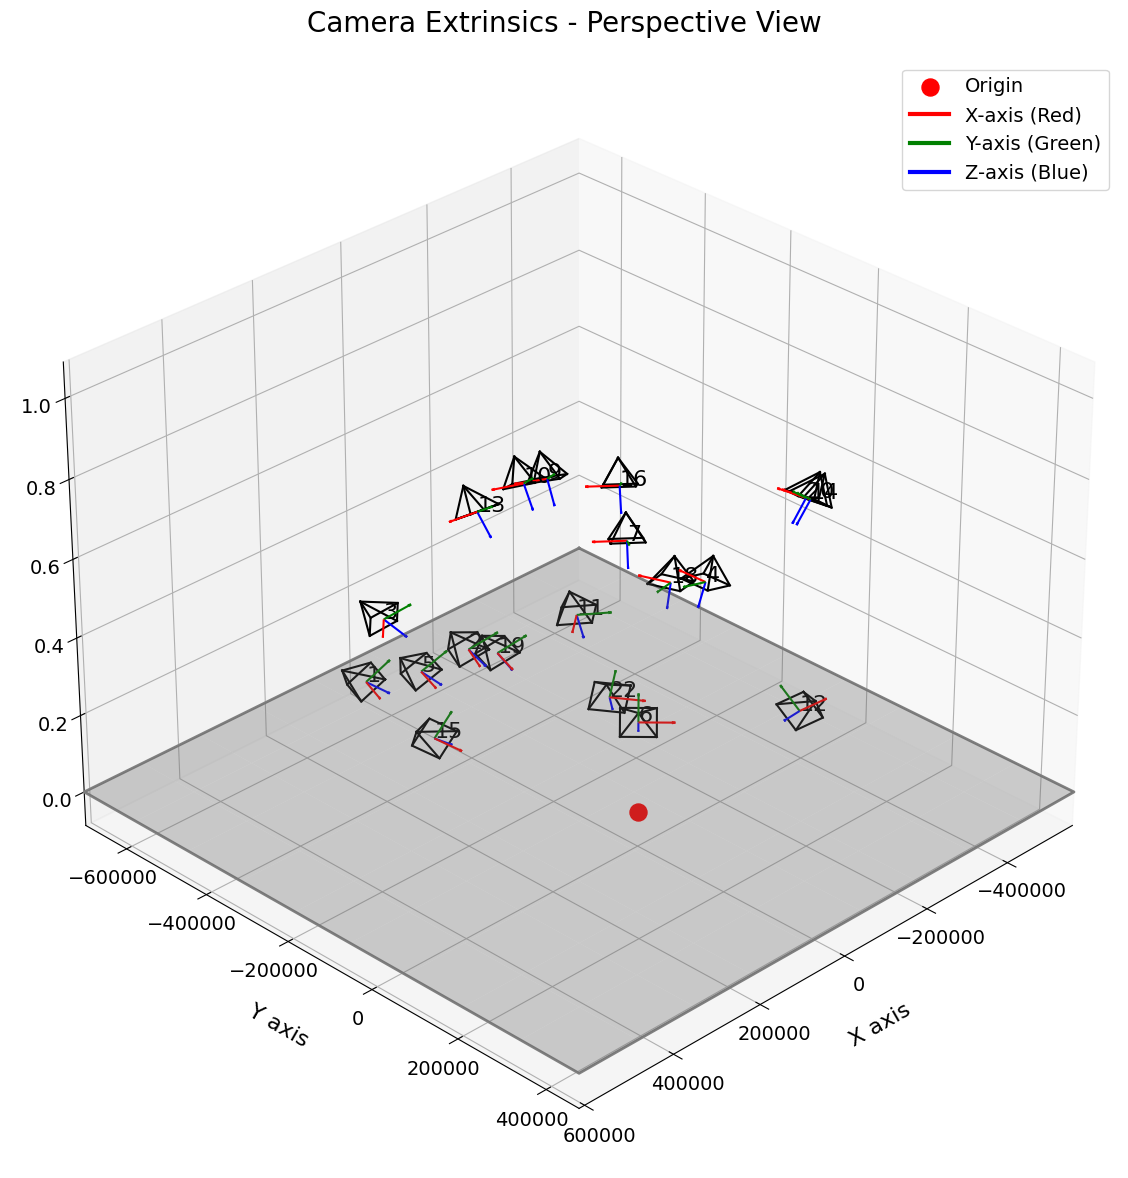

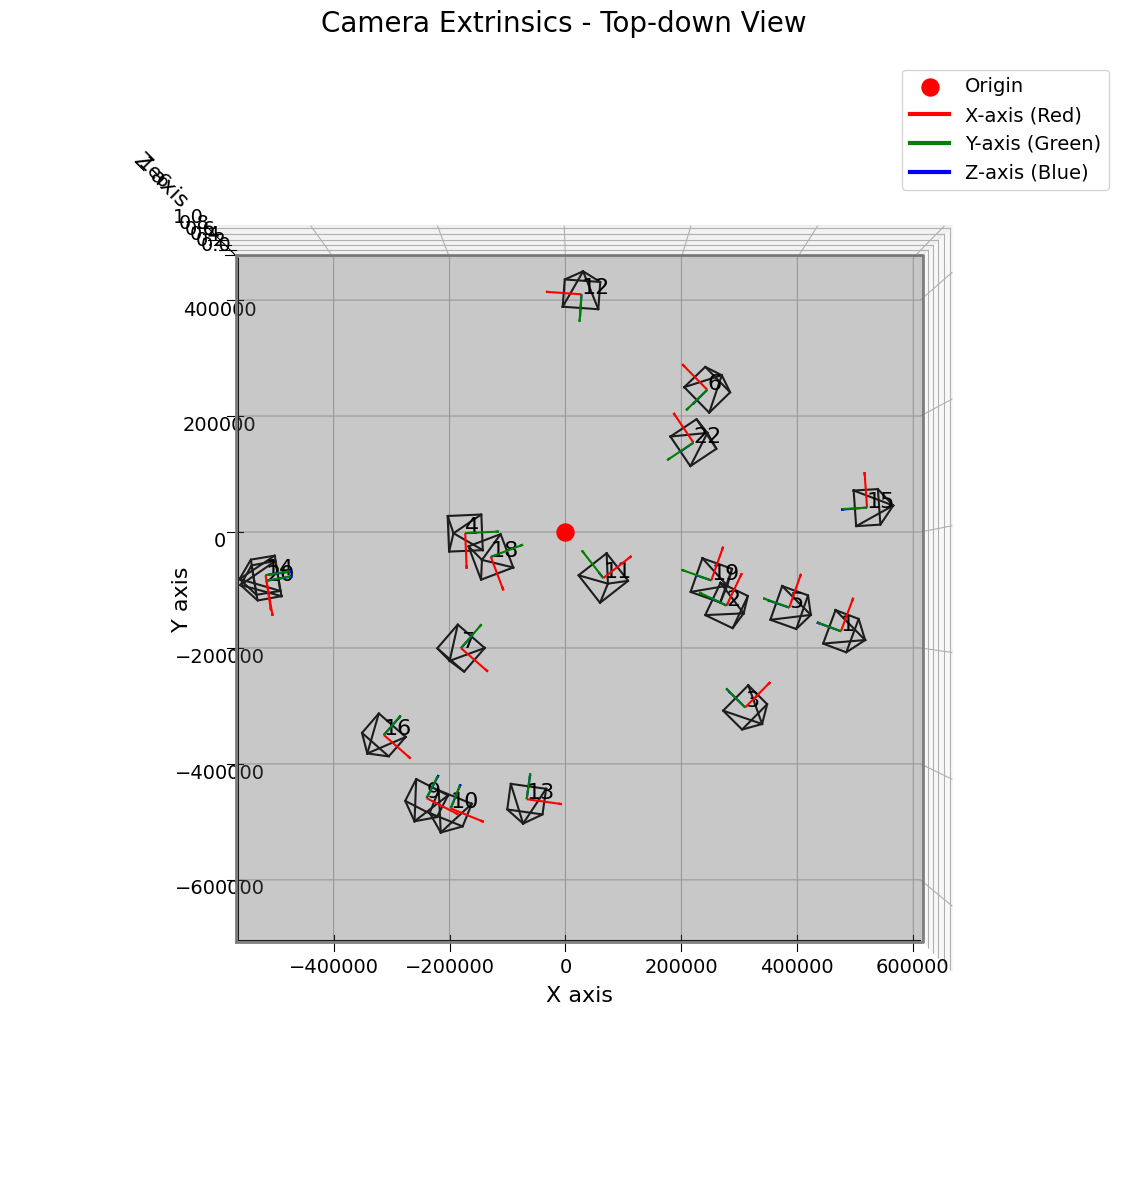

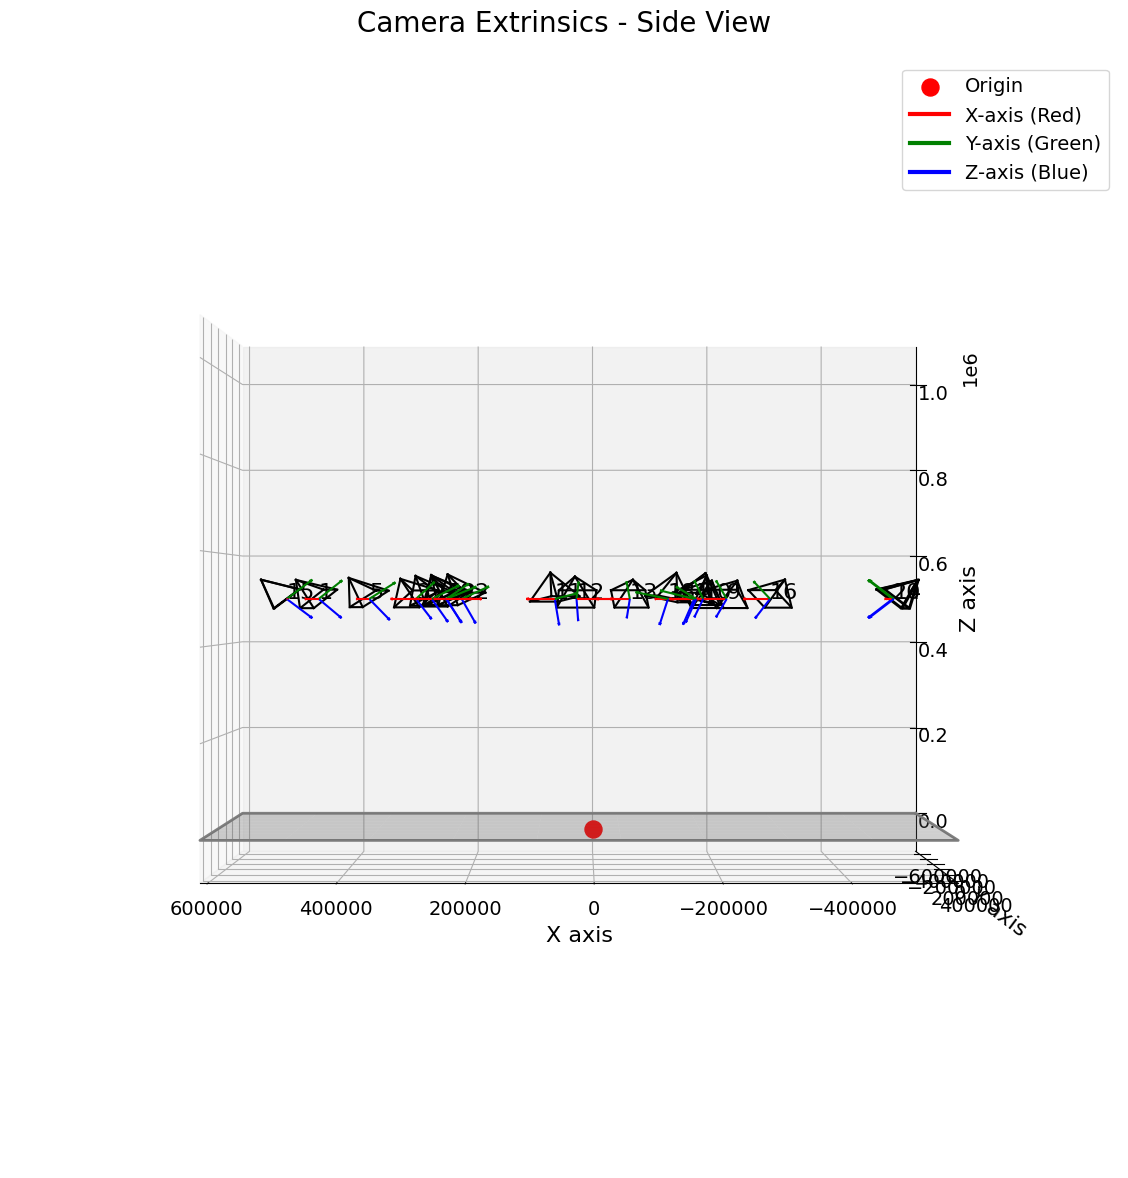

In [89]:
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set global font size parameters for matplotlib
plt.rcParams['font.size'] = 14  # Increase the base font size
plt.rcParams['axes.labelsize'] = 16  # Axis labels
plt.rcParams['axes.titlesize'] = 18  # Plot title
plt.rcParams['legend.fontsize'] = 14  # Legend text
plt.rcParams['xtick.labelsize'] = 14  # X tick labels
plt.rcParams['ytick.labelsize'] = 14  # Y tick labels

def load_extrinsics(json_file):
    """Load extrinsics from JSON file"""
    with open(json_file, 'r') as f:
        extrinsics_dict = json.load(f)
    
    # Convert string keys back to integers for sorting
    extrinsics_dict = {int(k): np.array(v) for k, v in extrinsics_dict.items()}
    
    # Sort by key for consistent ordering
    extrinsics_dict = {k: extrinsics_dict[k] for k in sorted(extrinsics_dict.keys())}
    
    return extrinsics_dict

def get_camera_poses(extrinsics_dict):
    """Convert extrinsics to camera poses in world coordinates"""
    camera_poses = {}
    
    for idx, extrinsic in extrinsics_dict.items():
        # Extract rotation and translation
        R_world_to_cam = extrinsic[:, :3]
        t_world_to_cam = extrinsic[:, 3]
        
        # Convert back to world coordinates
        R_cam_to_world = R_world_to_cam.T
        t_cam_to_world = -R_cam_to_world @ t_world_to_cam
        
        camera_poses[idx] = {
            'R': R_cam_to_world,
            't': t_cam_to_world
        }
    
    return camera_poses

def draw_camera(ax, R, t, scale=100000, label=None):
    """Draw a camera as a pyramid with its principal axis and explicit RGB axes"""
    # Camera center
    center = t
    
    # Define axes - explicitly use columns of R for world-to-camera transformation
    # In standard computer vision convention:
    # R[:,0] = X-axis (red)
    # R[:,1] = Y-axis (green)
    # R[:,2] = Z-axis (blue)
    
    # Explicitly draw the axes with proper colors
    x_axis_vec = R[:, 0] * scale
    y_axis_vec = R[:, 1] * scale
    z_axis_vec = R[:, 2] * scale
    
    # X-axis - RED
    ax.quiver(center[0], center[1], center[2], 
              x_axis_vec[0], x_axis_vec[1], x_axis_vec[2], 
              color='red', arrow_length_ratio=0.1, label='X' if label == '0' else None)
    
    # Y-axis - GREEN
    ax.quiver(center[0], center[1], center[2], 
              y_axis_vec[0], y_axis_vec[1], y_axis_vec[2], 
              color='green', arrow_length_ratio=0.1, label='Y' if label == '0' else None)
    
    # Z-axis - BLUE
    ax.quiver(center[0], center[1], center[2], 
              z_axis_vec[0], z_axis_vec[1], z_axis_vec[2], 
              color='blue', arrow_length_ratio=0.1, label='Z' if label == '0' else None)
    
    # Draw a simple pyramid to represent the camera
    # Define pyramid vertices with explicit color-coded axes
    pyramid_scale = scale * 0.5
    
    # Use the same convention for the base of the pyramid
    base_points = np.array([
        center + x_axis_vec * 0.5 + y_axis_vec * 0.5,
        center + x_axis_vec * 0.5 - y_axis_vec * 0.5,
        center - x_axis_vec * 0.5 - y_axis_vec * 0.5,
        center - x_axis_vec * 0.5 + y_axis_vec * 0.5
    ])
    
    # Apex is in the negative z-direction
    apex = center - z_axis_vec
    
    # Draw base of pyramid
    base_x = [p[0] for p in base_points] + [base_points[0][0]]
    base_y = [p[1] for p in base_points] + [base_points[0][1]]
    base_z = [p[2] for p in base_points] + [base_points[0][2]]
    ax.plot(base_x, base_y, base_z, 'k-')
    
    # Draw lines from apex to base
    for point in base_points:
        ax.plot([apex[0], point[0]], 
                [apex[1], point[1]], 
                [apex[2], point[2]], 'k-')
    
    # Add label if provided
    if label is not None:
        ax.text(center[0], center[1], center[2], label, fontsize=16)  # Increased label font size

def draw_ground_plane(ax, center, max_range):
    """Draw a grey box at z=0"""
    # Define the corners of the box at z=0
    x_min, x_max = center[0] - max_range, center[0] + max_range
    y_min, y_max = center[1] - max_range, center[1] + max_range
    
    # Create a grid for the ground plane
    x_grid = np.linspace(x_min, x_max, 10)
    y_grid = np.linspace(y_min, y_max, 10)
    x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
    z_mesh = np.zeros_like(x_mesh)  # z=0 plane
    
    # Plot the ground plane
    ax.plot_surface(x_mesh, y_mesh, z_mesh, color='gray', alpha=0.3)
    
    # Draw the boundary of the ground plane
    ax.plot([x_min, x_max, x_max, x_min, x_min],
            [y_min, y_min, y_max, y_max, y_min],
            [0, 0, 0, 0, 0], 'gray', linewidth=2)

def visualize_camera_extrinsics(extrinsics_file):
    """Visualize camera extrinsics from multiple views"""
    # Load extrinsics
    extrinsics_dict = load_extrinsics(extrinsics_file)
    
    # Convert to camera poses in world coordinates
    camera_poses = get_camera_poses(extrinsics_dict)
    
    # Get camera positions
    camera_positions = np.array([pose['t'] for pose in camera_poses.values()])
    
    # Calculate center and scale for plotting
    center = np.mean(camera_positions, axis=0)
    max_range = 2 * np.max(np.std(camera_positions, axis=0))
    
    # Views with consistent camera positions and axes
    views = [
        {'elev': 30, 'azim': 45, 'title': 'Camera Extrinsics - Perspective View', 'filename': 'extrinsics_view1.png'},
        {'elev': 90, 'azim': -90, 'title': 'Camera Extrinsics - Top-down View', 'filename': 'extrinsics_view2.png'},
        {'elev': 0, 'azim': 90, 'title': 'Camera Extrinsics - Side View', 'filename': 'extrinsics_view3.png'}
    ]
    
    for view in views:
        fig = plt.figure(figsize=(14, 12))  # Increased figure size for better visibility
        ax = fig.add_subplot(111, projection='3d')
        
        # Draw the z=0 plane
        draw_ground_plane(ax, center, max_range)
        
        # Draw each camera
        for idx, pose in camera_poses.items():
            draw_camera(ax, pose['R'], pose['t'], scale=max_range*0.1, label=str(idx))
        
        # Add origin
        ax.scatter([0], [0], [0], color='red', s=150, marker='o', label='Origin')  # Increased marker size
        
        # Add a legend for axes colors with increased size
        ax.plot([], [], 'r-', linewidth=3, label='X-axis (Red)')
        ax.plot([], [], 'g-', linewidth=3, label='Y-axis (Green)')
        ax.plot([], [], 'b-', linewidth=3, label='Z-axis (Blue)')
        ax.legend(fontsize=14, loc='best')
        
        # Set labels and title with larger font size
        ax.set_xlabel('X axis', fontsize=16, labelpad=15)
        ax.set_ylabel('Y axis', fontsize=16, labelpad=15)
        ax.set_zlabel('Z axis', fontsize=16, labelpad=15)
        ax.set_title(view['title'], fontsize=20, pad=20)
        
        # Increase tick label size
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.tick_params(axis='z', labelsize=14)
        
        # Set equal aspect ratio
        ax.set_xlim(center[0] - max_range, center[0] + max_range)
        ax.set_ylim(center[1] - max_range, center[1] + max_range)
        ax.set_zlim(center[2] - max_range, center[2] + max_range)
        
        # Set view angle
        ax.view_init(elev=view['elev'], azim=view['azim'])
        
        plt.tight_layout()
        plt.savefig(view['filename'], dpi=300)
        plt.show()

if __name__ == "__main__":
    # Change this to your extrinsics JSON file
    extrinsics_file = "camera_extrinsics.json"
    visualize_camera_extrinsics(extrinsics_file)